# 4. single-cell, aggregated and consensus profiles PCA plot 

This notebook compares single-cell, replicate-aggregate, and consensus profiles in PCA space for CFReT cardiac fibroblast data. It visualizes how different aggregation strategies (replicate-level and consensus) are positioned within the underlying single-cell distribution across multiple conditions (healthy/failing cells with various treatments: DMSO, TGFRi, drug_x).


In [1]:
suppressPackageStartupMessages({library(arrow)
library(dplyr)
library(ggplot2)
library(tidyr)
library(viridis)
library(RColorBrewer)
library(IRdisplay)})


setting input and output paths

In [2]:
data_dir <- file.path("../../0.download-data/data/sc-profiles")
figures_dir <- file.path("./figures")
module_results_path <- file.path("../results")

cfret_profiles <- file.path(data_dir, "cfret/localhost230405150001_sc_feature_selected.parquet")
consensus_profiles_path <- file.path(module_results_path, "aggregate_profiles/cfret_consensus_profiles.parquet")
rep_agg_profiles_path <- file.path(module_results_path, "aggregate_profiles/cfret_replicate_profiles.parquet")

dir.create(figures_dir, showWarnings = FALSE, recursive = TRUE)

Loading in profiles

In [3]:
cfret_df <- read_parquet(cfret_profiles)
consensus_df <- read_parquet(consensus_profiles_path)
rep_agg_df <- read_parquet(rep_agg_profiles_path)

cfret_df$Metadata_data_type <- "single-cell"
consensus_df$Metadata_data_type <- "consensus"
rep_agg_df$Metadata_data_type <- "replicate-aggregate"

meta_cols <- grep("^Metadata_", colnames(cfret_df), value = TRUE)
feature_cols <- setdiff(colnames(cfret_df), meta_cols)

cfret_meta <- meta_cols
cfret_features <- feature_cols
consensus_meta <- grep("^Metadata_", colnames(consensus_df), value = TRUE)
consensus_features <- setdiff(colnames(consensus_df), consensus_meta)
rep_agg_meta <- grep("^Metadata_", colnames(rep_agg_df), value = TRUE)
rep_agg_features <- setdiff(colnames(rep_agg_df), rep_agg_meta)

if (!identical(sort(cfret_features), sort(consensus_features))) {
  stop("CFRET and Consensus feature spaces do not match!")
}
if (!identical(sort(cfret_features), sort(rep_agg_features))) {
  stop("CFRET and Replicate Aggregate feature spaces do not match!")
}

Here we are creating a PCA model that takes in the single-cell, replicate aggregate and the consensus profiles.

In [4]:
options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 300)
selected_metadata_cols <- c("Metadata_data_type", "Metadata_cell_type", "Metadata_treatment")

concat_df <- bind_rows(
  cfret_df[, c(selected_metadata_cols, cfret_features)],
  consensus_df[, c(selected_metadata_cols, cfret_features)],
  rep_agg_df[, c(selected_metadata_cols, cfret_features)]
)

feature_matrix <- as.matrix(concat_df[, cfret_features])
pca_model <- prcomp(feature_matrix, center = TRUE, scale. = TRUE)

var_explained <- cumsum(pca_model$sdev^2) / sum(pca_model$sdev^2)
n_components <- which(var_explained >= 0.95)[1]

pca_scores <- as.data.frame(pca_model$x[, 1:n_components])
concat_df_pca <- cbind(concat_df[, selected_metadata_cols], pca_scores)


Saved PNG to: ./figures/pca_single_cell_vs_aggregate.png


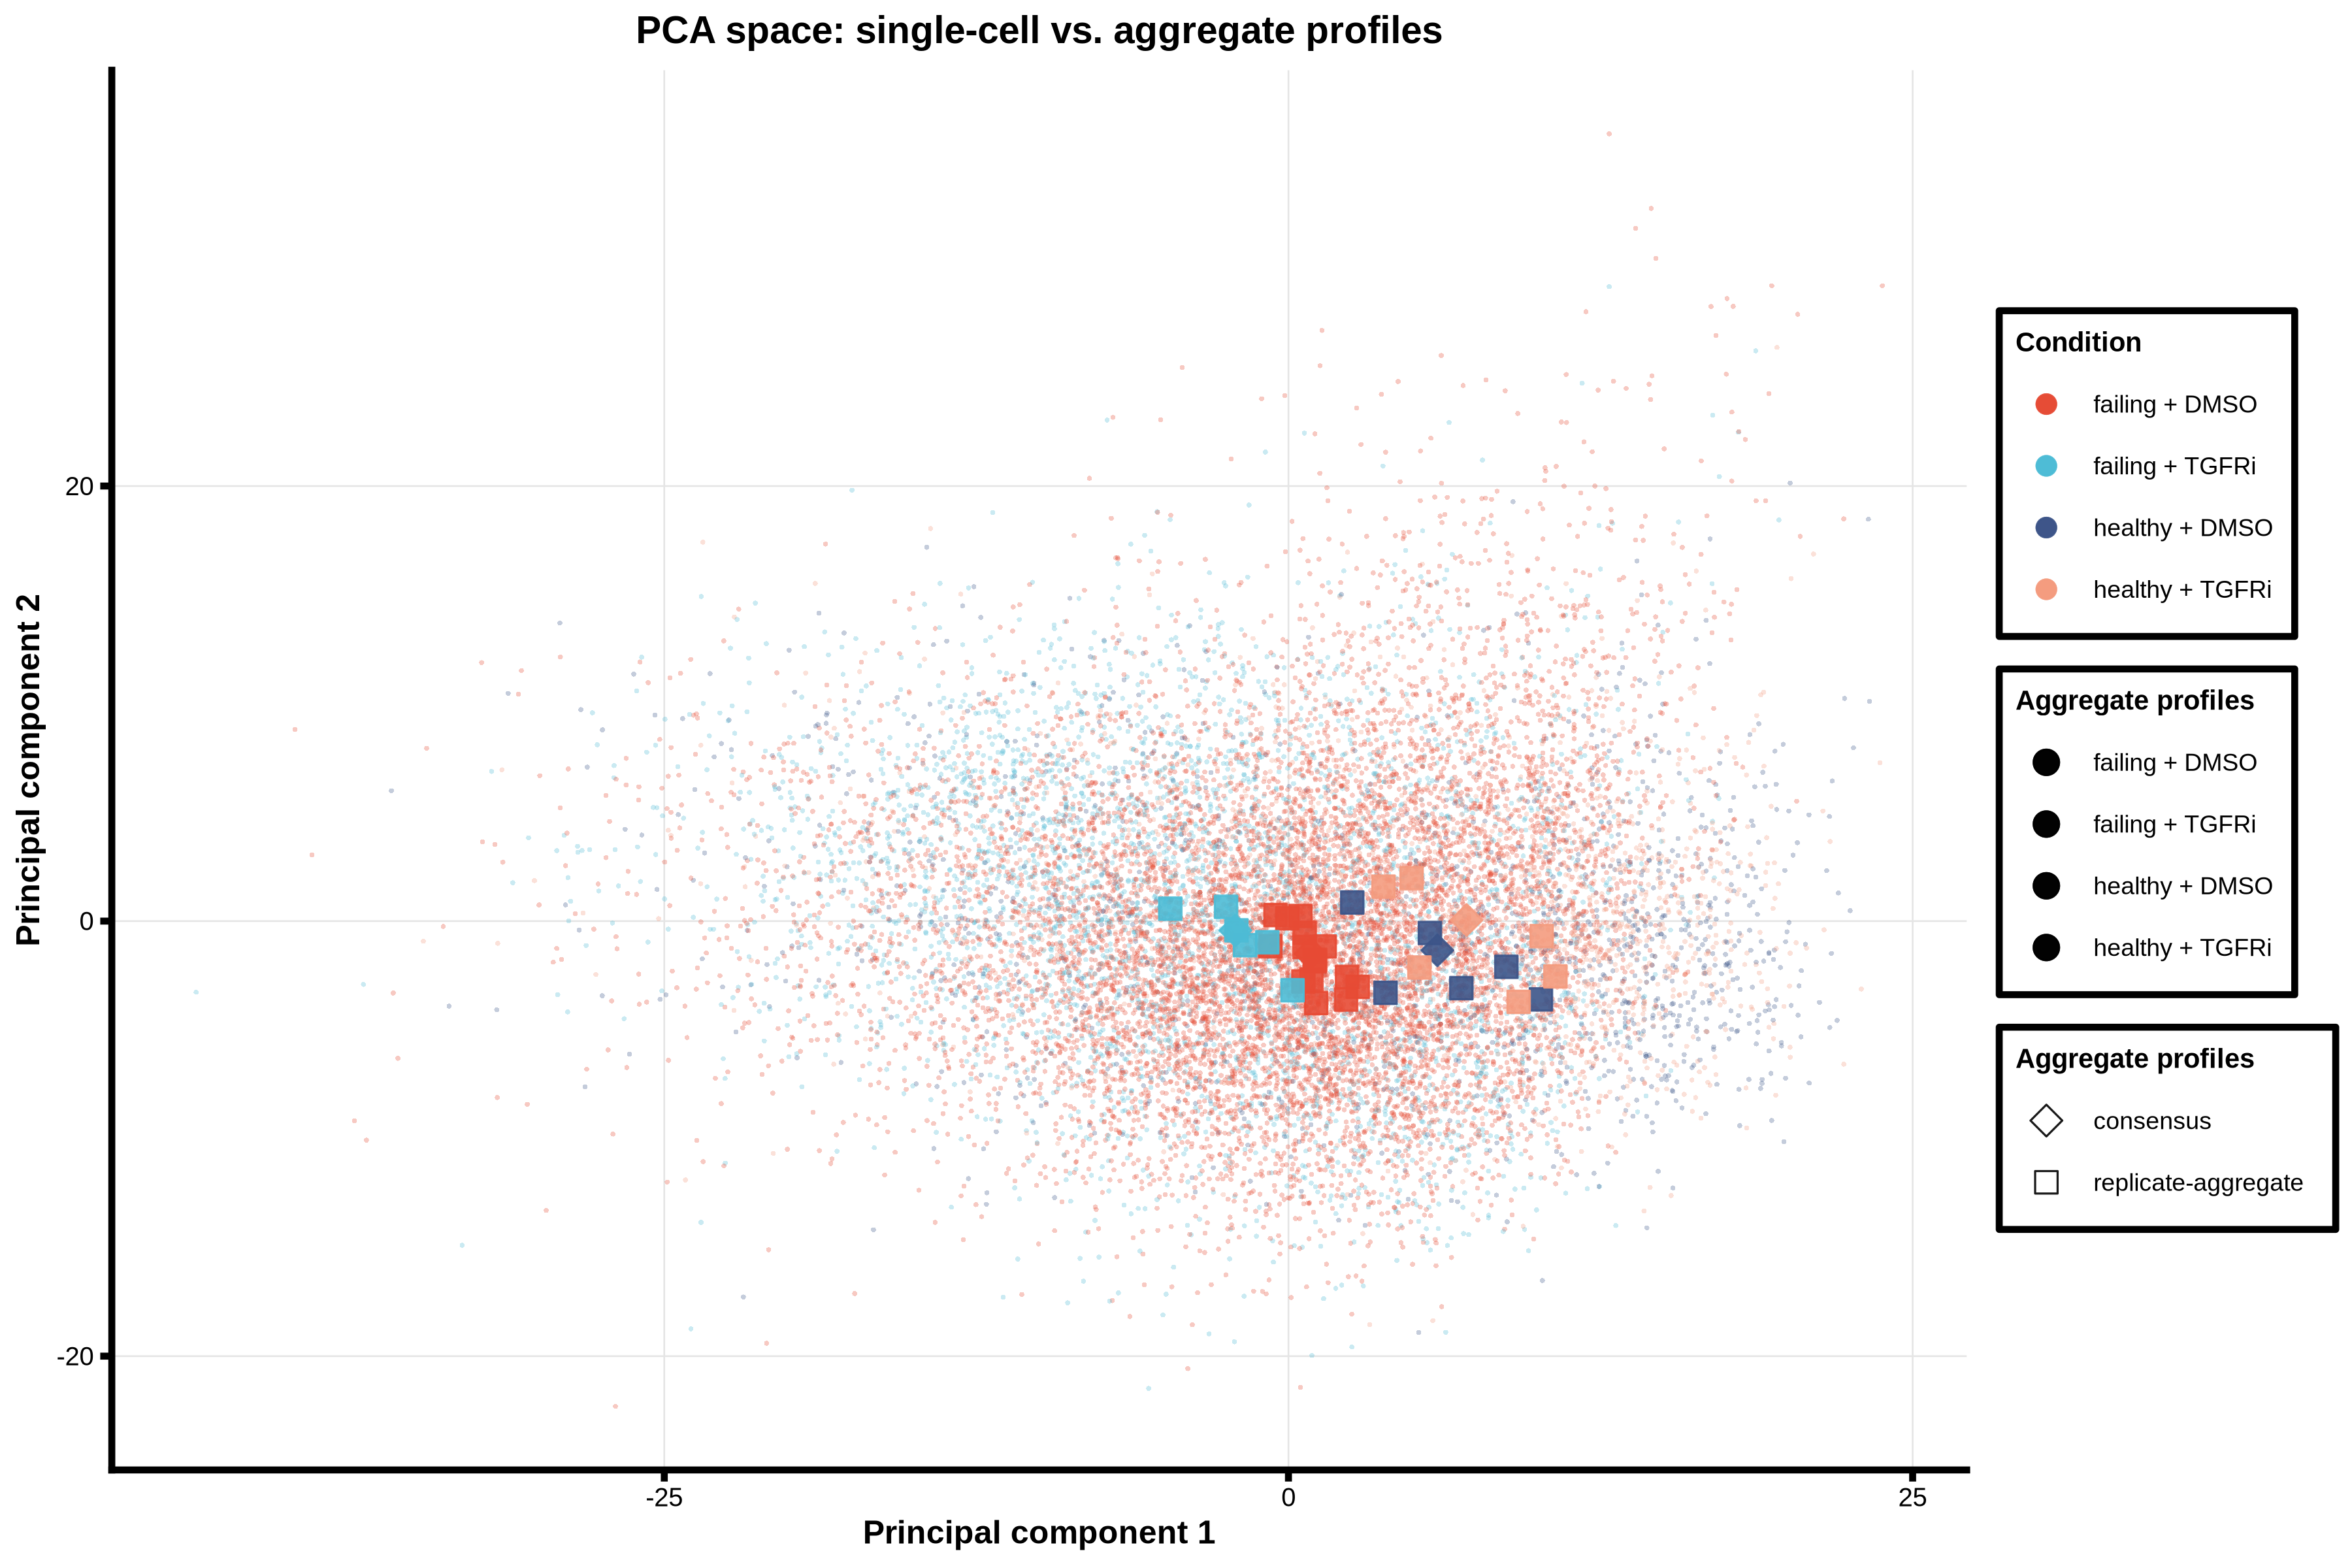

In [5]:
single_cell_data <- concat_df_pca %>%
  filter(Metadata_data_type == "single-cell") %>%
  mutate(Condition = paste(Metadata_cell_type, Metadata_treatment, sep = " + "))

consensus_data <- concat_df_pca %>%
  filter(Metadata_data_type == "consensus") %>%
  mutate(Condition = paste(Metadata_cell_type, Metadata_treatment, sep = " + "))

rep_agg_data <- concat_df_pca %>%
  filter(Metadata_data_type == "replicate-aggregate") %>%
  mutate(Condition = paste(Metadata_cell_type, Metadata_treatment, sep = " + "))

condition_colors <- c(
  "failing + DMSO" = "#E64B35",
  "failing + TGFRi" = "#4DBBD5",
  "failing + drug_x" = "#00A087",
  "healthy + DMSO" = "#3C5488",
  "healthy + TGFRi" = "#F39B7F",
  "healthy + drug_x" = "#8491B4"
)

shape_map <- c(
  "consensus" = 23,
  "replicate-aggregate" = 22
)

pca_plot <- ggplot() +
  geom_point(
    data = single_cell_data,
    aes(x = PC1, y = PC2, color = Condition),
    size = 0.5,
    alpha = 0.3,
    shape = 16
  ) +
  geom_point(
    data = consensus_data,
    aes(x = PC1, y = PC2, color = Condition, fill = Condition, shape = Metadata_data_type),
    size = 4,
    alpha = 0.9
  ) +
  geom_point(
    data = rep_agg_data,
    aes(x = PC1, y = PC2, color = Condition, fill = Condition, shape = Metadata_data_type),
    size = 4,
    alpha = 0.9
  ) +
  scale_color_manual(
    values = condition_colors,
    name = "Condition"
  ) +
  scale_fill_manual(
    values = condition_colors,
    name = "Condition"
  ) +
  scale_shape_manual(
    values = shape_map,
    name = "Aggregate profiles"
  ) +
  labs(
    x = "Principal component 1",
    y = "Principal component 2",
    title = "PCA space: single-cell vs. aggregate profiles"
  ) +
  theme_classic(base_size = 12) +
  theme(
    text = element_text(family = "sans"),
    plot.title = element_text(face = "bold", size = 14, hjust = 0.5),
    axis.title = element_text(face = "bold", size = 12),
    axis.line = element_line(linewidth = 1.2),
    axis.ticks = element_line(linewidth = 1.2),
    axis.ticks.length = unit(0.15, "cm"),
    legend.position = "right",
    legend.box = "vertical",
    legend.title = element_text(face = "bold", size = 10),
    legend.text = element_text(size = 9),
    legend.key.size = unit(0.8, "cm"),
    legend.background = element_rect(color = "black", linewidth = 1.2),
    panel.grid.major = element_line(color = "gray90", linewidth = 0.3),
    panel.grid.minor = element_blank()
  ) +
  guides(
    color = guide_legend(
      override.aes = list(size = 3, alpha = 0.8),
      order = 1
    ),
    fill = guide_legend(
      override.aes = list(size = 4),
      order = 2,
      title = "Aggregate profiles"
    )
  )

# Save plots
output_path_png <- file.path(figures_dir, "pca_single_cell_vs_aggregate.png")

ggsave(output_path_png, plot = pca_plot, width = 12, height = 8, dpi = 300, bg = "white")

cat(sprintf("\nSaved PNG to: %s\n", output_path_png))

pca_plot


Saved PNG to: ./figures/pca_selected_conditions.png


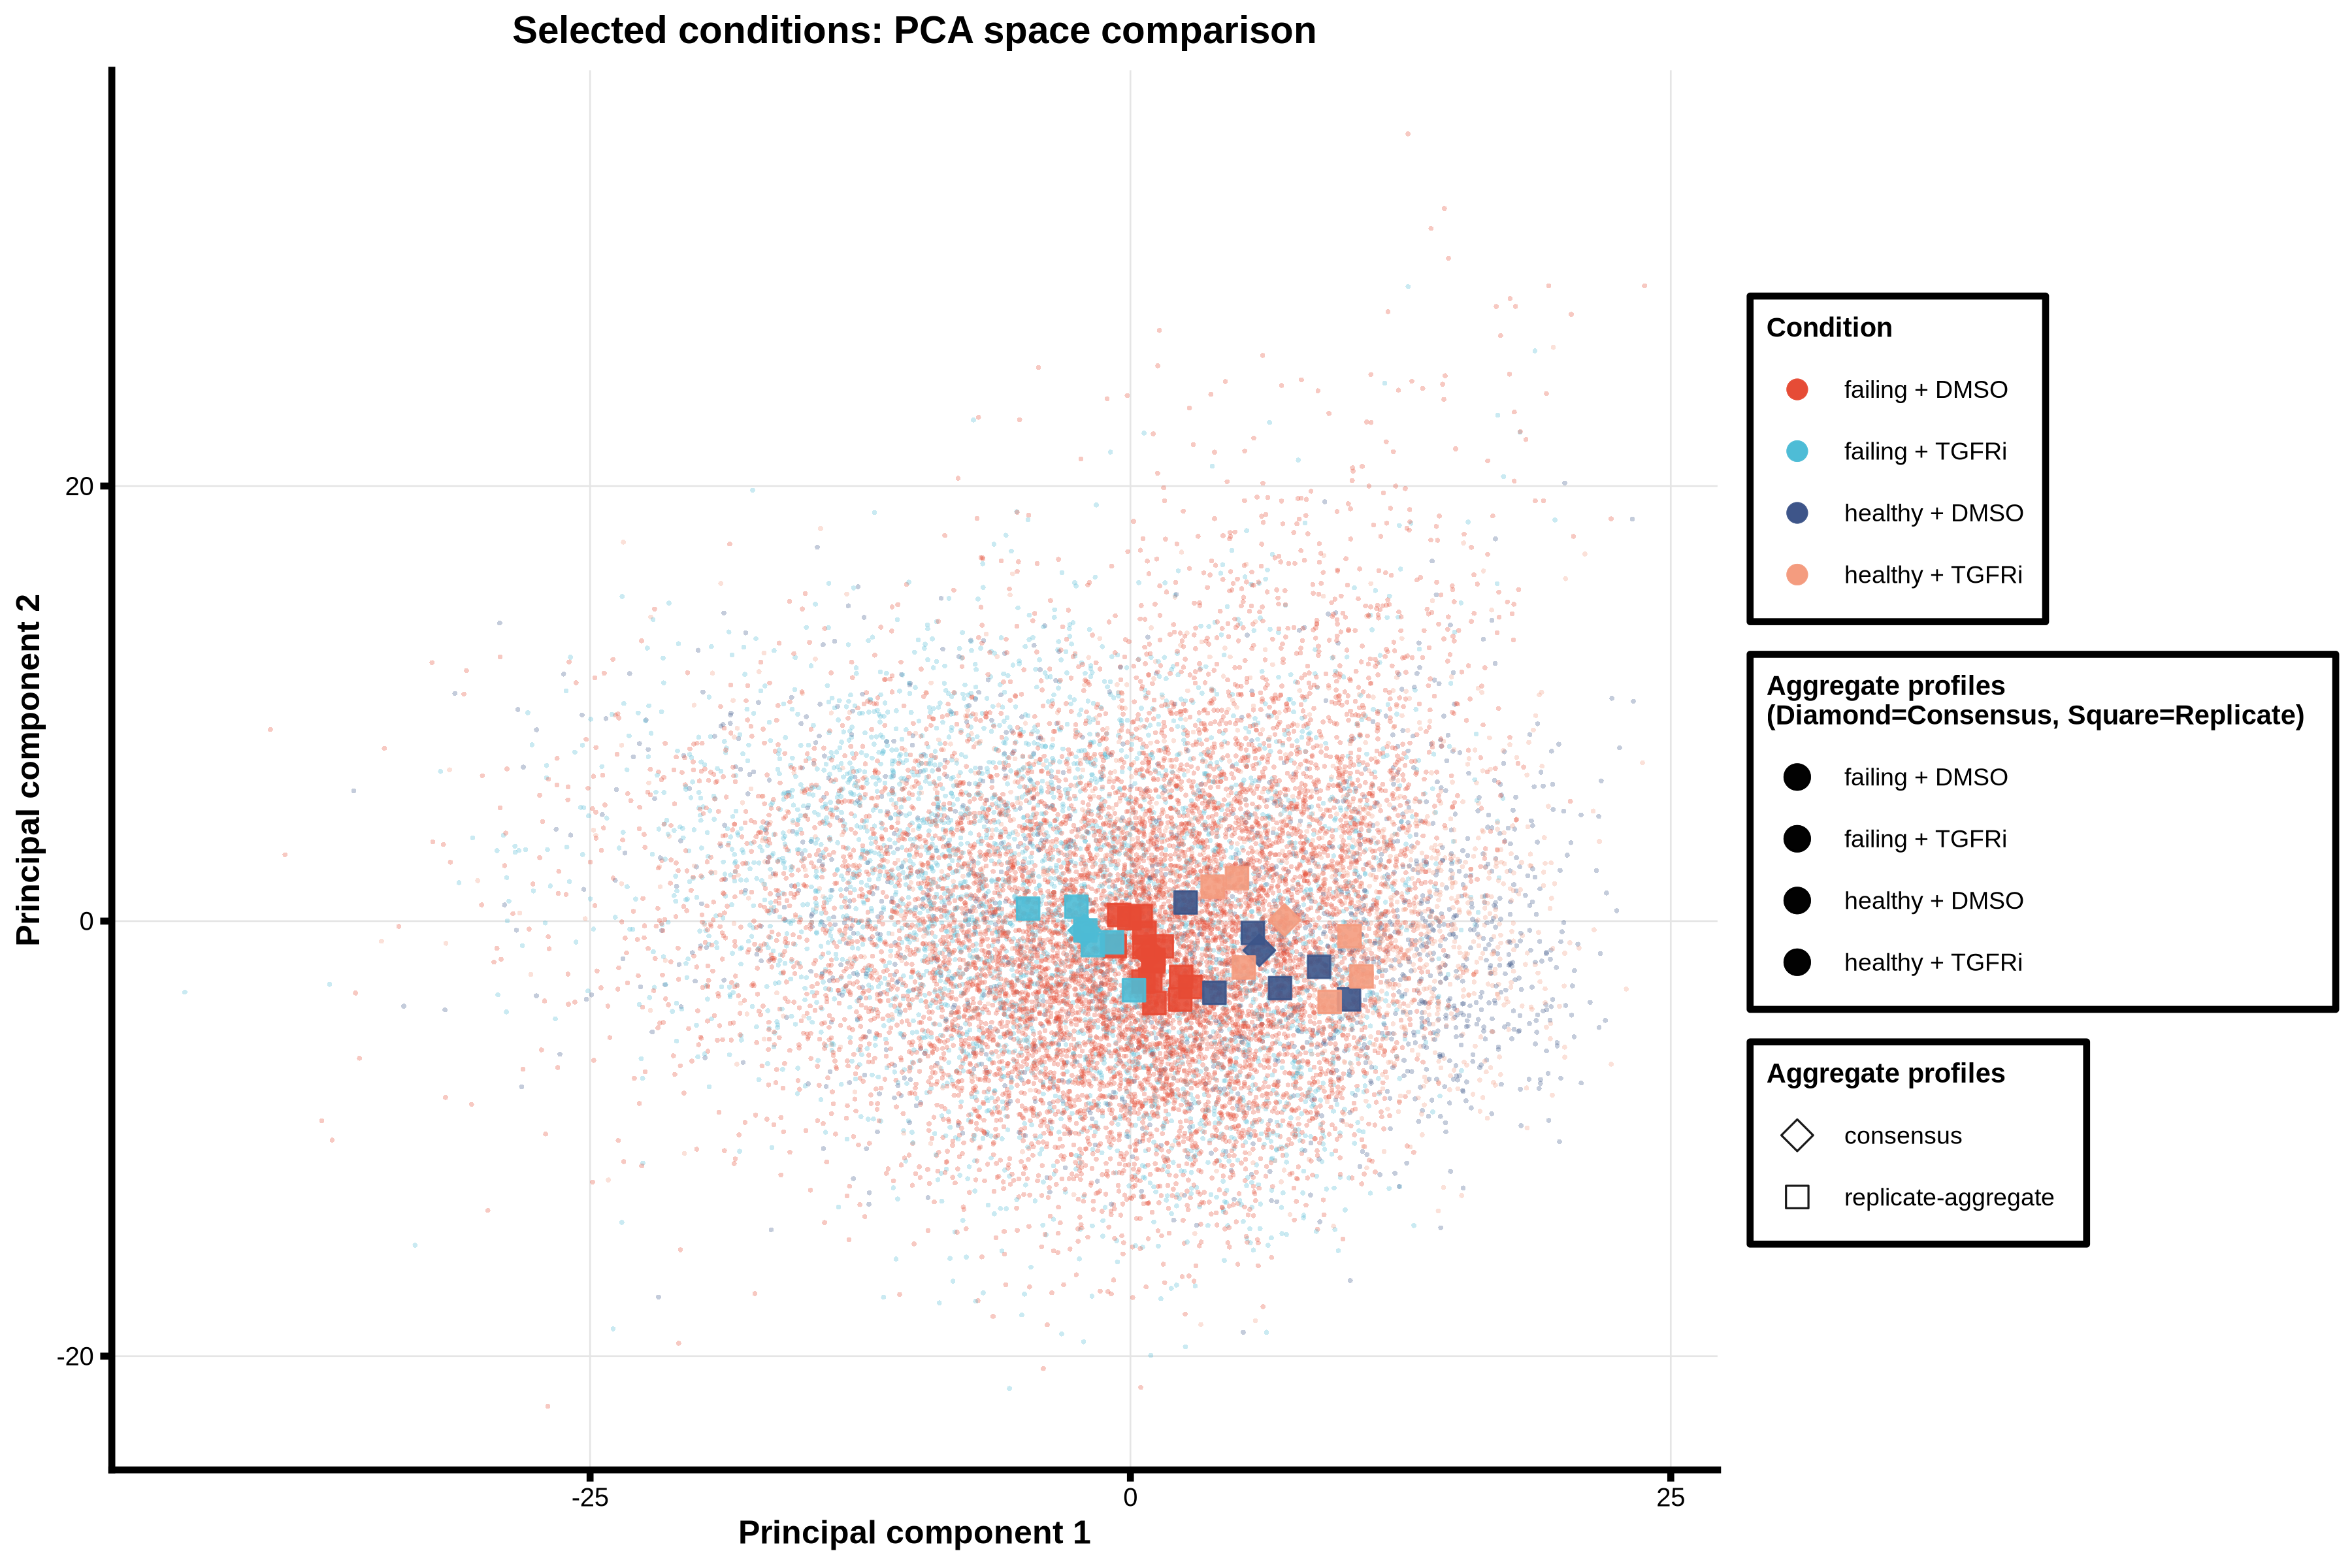

In [6]:
selected_conditions <- c("failing + DMSO", "failing + TGFRi", "healthy + DMSO", "healthy + TGFRi")

single_cell_filtered <- single_cell_data %>%
  filter(Condition %in% selected_conditions)

consensus_filtered <- consensus_data %>%
  filter(Condition %in% selected_conditions)

rep_agg_filtered <- rep_agg_data %>%
  filter(Condition %in% selected_conditions)

p_filtered <- ggplot() +
  geom_point(
    data = single_cell_filtered,
    aes(x = PC1, y = PC2, color = Condition),
    size = 0.5,
    alpha = 0.3,
    shape = 16
  ) +
  geom_point(
    data = consensus_filtered,
    aes(x = PC1, y = PC2, color = Condition, fill = Condition, shape = Metadata_data_type),
    size = 4,
    alpha = 0.9
  ) +
  geom_point(
    data = rep_agg_filtered,
    aes(x = PC1, y = PC2, color = Condition, fill = Condition, shape = Metadata_data_type),
    size = 4,
    alpha = 0.9
  ) +
  scale_color_manual(
    values = condition_colors,
    name = "Condition"
  ) +
  scale_fill_manual(
    values = condition_colors,
    name = "Condition"
  ) +
  scale_shape_manual(
    values = shape_map,
    name = "Aggregate profiles"
  ) +
  labs(
    x = "Principal component 1",
    y = "Principal component 2",
    title = "Selected conditions: PCA space comparison"
  ) +
  theme_classic(base_size = 12) +
  theme(
    text = element_text(family = "sans"),
    plot.title = element_text(face = "bold", size = 14, hjust = 0.5),
    axis.title = element_text(face = "bold", size = 12),
    axis.line = element_line(linewidth = 1.2),
    axis.ticks = element_line(linewidth = 1.2),
    axis.ticks.length = unit(0.15, "cm"),
    legend.position = "right",
    legend.box = "vertical",
    legend.title = element_text(face = "bold", size = 10),
    legend.text = element_text(size = 9),
    legend.key.size = unit(0.8, "cm"),
    legend.background = element_rect(color = "black", linewidth = 1.2),
    panel.grid.major = element_line(color = "gray90", linewidth = 0.3),
    panel.grid.minor = element_blank()
  ) +
  guides(
    color = guide_legend(
      override.aes = list(size = 3, alpha = 0.8),
      order = 1
    ),
    fill = guide_legend(
      override.aes = list(size = 4),
      order = 2,
      title = "Aggregate profiles\n(Diamond=Consensus, Square=Replicate)"
    )
  )

# Save plots
output_path_filtered_png <- file.path(figures_dir, "pca_selected_conditions.png")

ggsave(output_path_filtered_png, plot = p_filtered, width = 12, height = 8, dpi = 300, bg = "white")

cat(sprintf("\nSaved PNG to: %s\n", output_path_filtered_png))

p_filtered